- Here, I use real data for the bus stops optimization problem. 
- We have 119 potential bus stop locations and strictly 10 bus stops to find to be the best.
- I assume that the minimum route from the employee to the bus stop is euclidian distance, and neglect the fact that there are trajectories along the road

# 1) Optimize GP - 200 iterations

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from skopt import gp_minimize
from scipy.spatial.distance import cdist
from skopt.space import Integer
import pickle

In [2]:
b = pd.read_csv('Potentail_Bust_Stops_lat_long_corrected.csv').drop(columns="Unnamed: 0")
a = pd.read_csv('Employee_Addresses_lat_long.csv').set_index('employee_id')

b = b[['latitude', 'longitude']].sort_values(by='latitude')
a = a[['latitude', 'longitude']]

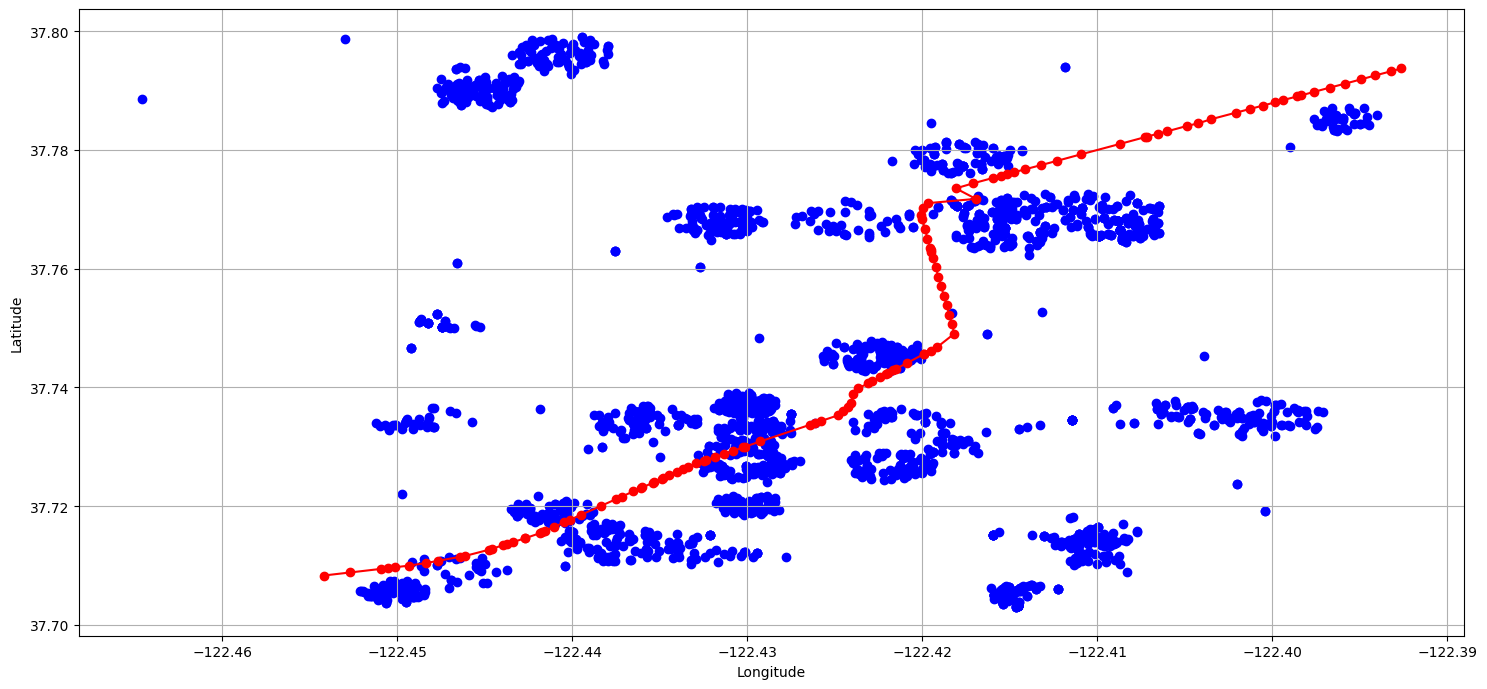

In [3]:
fig, axs = plt.subplots(1, 1, figsize=(15, 7))

# Plot 1 - potential bus stops
axs.plot(b['longitude'], b['latitude'],  '-o', c='red')
axs.set_xlabel('Longitude'); axs.set_ylabel('Latitude'); axs.grid(True)

# Plot 2 - addresses of all employees
axs.scatter(a['longitude'], a['latitude'], c='blue', marker='o')
plt.tight_layout()

In [4]:
b = b[['latitude', 'longitude']].to_numpy()
a = a[['latitude', 'longitude']].to_numpy()

n_points = len(b)
subset_size = 10

In [ ]:
space = [Integer(0, n_points-1) for _ in range(subset_size)]
space

[Integer(low=0, high=118, prior='uniform', transform='identity'),
 Integer(low=0, high=118, prior='uniform', transform='identity'),
 Integer(low=0, high=118, prior='uniform', transform='identity'),
 Integer(low=0, high=118, prior='uniform', transform='identity'),
 Integer(low=0, high=118, prior='uniform', transform='identity'),
 Integer(low=0, high=118, prior='uniform', transform='identity'),
 Integer(low=0, high=118, prior='uniform', transform='identity'),
 Integer(low=0, high=118, prior='uniform', transform='identity'),
 Integer(low=0, high=118, prior='uniform', transform='identity'),
 Integer(low=0, high=118, prior='uniform', transform='identity')]

In [ ]:
penalty = 1e10

def objective(indices):
    
    if len(set(indices)) != len(indices): 
        return penalty 
    
    selected_points = b[np.array(indices, dtype=int)] 
    distances = cdist(a, selected_points)
    return np.sum(np.min(distances, axis=1))

result = gp_minimize( func=objective, 
                      dimensions=space,  # Search space
                      acq_func="EI",     # Expected improvement
                      n_calls=200,       # Number of iterations
                      random_state=42,
                      n_restarts_optimizer=5, 
                      acq_optimizer = 'auto',
                      verbose=True ) 

In [10]:
best_indices = result.x
selected_points = b[np.array(best_indices, dtype=int)]

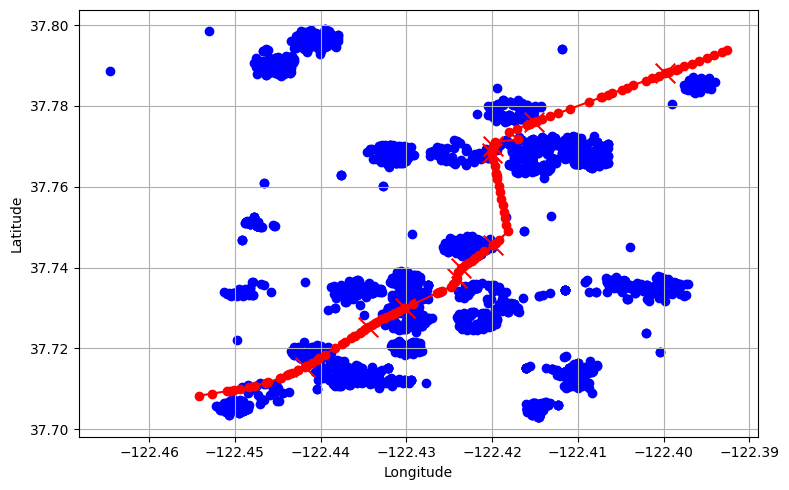

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5))

# Plot 1 - potential bus stops
axs.plot(b[:, 1], b[:, 0], '-o', c='red')
axs.set_xlabel('Longitude'); axs.set_ylabel('Latitude'); axs.grid(True)

# Plot 2 - addresses of all employees
axs.scatter(a[:, 1], a[:, 0], c='blue', marker='o')

# Plot 3 - selected points after optimization
axs.scatter(selected_points[:, 1], selected_points[:, 0], c='red', marker='x', s=200)
plt.tight_layout()

In [20]:
print("Best score:", result.fun)
print("Best combination of points:", result.x)

Best score: 26.15818504381774
Best combination of points: [34, 55, 108, 84, 64, 53, 82, 91, 45, 17]


# 2) Optimize GP - 1000 iterations

- Here, we try to increase the number of iterations. 
- Ideally we need to perform hyperparameters tuning, especially related to aquisition function.
- 1000 iterations takes around 12 hours to run on my Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz   1.80 GHz machine with 16 G RAM

In [ ]:
class CheckpointSaver:
    def __init__(self, save_interval=50, filepath="checkpoint.pkl"):
        self.save_interval = save_interval
        self.filepath = filepath
    
    def __call__(self, res):
        if len(res.func_vals) % self.save_interval == 0:
            with open(self.filepath, "wb") as f:
                pickle.dump(res, f)
            print(f"Checkpoint saved at iteration {len(res.func_vals)}")

checkpoint_saver = CheckpointSaver(save_interval=100, filepath="checkpoint.pkl")            

In [ ]:
penalty = 1e10

def objective(indices):
    
    if len(set(indices)) != len(indices): 
        return penalty 
    
    selected_points = b[np.array(indices, dtype=int)] 
    distances = cdist(a, selected_points)
    return np.sum(np.min(distances, axis=1))

result = gp_minimize( func=objective, 
                      dimensions=space,  # Search space
                      acq_func="EI",     # Expected improvement
                      n_calls=1000,      # Number of iterations
                      random_state=42,
                      n_restarts_optimizer=5, 
                      acq_optimizer = 'auto',
                      callback=[checkpoint_saver] ) 

In [16]:
with open("checkpoint.pkl", "rb") as f:
    result_ckpt = pickle.load(f)   

In [17]:
best_indices = result_ckpt.x
selected_points = b[np.array(best_indices, dtype=int)]

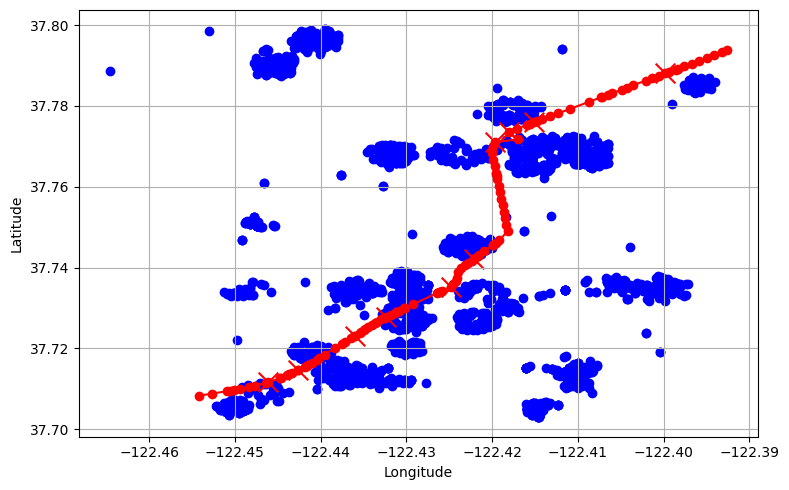

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5))

# Plot 1 - potential bus stops
axs.plot(b[:, 1], b[:, 0], '-o', c='red')
axs.set_xlabel('Longitude'); axs.set_ylabel('Latitude'); axs.grid(True)

# Plot 2 - addresses of all employees
axs.scatter(a[:, 1], a[:, 0], c='blue', marker='o')

# Plot 3 - selected points after optimization
axs.scatter(selected_points[:, 1], selected_points[:, 0], c='red', marker='x', s=200)
plt.tight_layout()

In [19]:
print("Best score:", result_ckpt.fun)
print("Best combination of points:", result_ckpt.x)

Best score: 26.033843514478846
Best combination of points: [29, 9, 108, 91, 50, 40, 16, 85, 87, 59]


# Results

- We see that more iterations leads to slightly better (lower) score of 26.03 compared to 26.16 when 200 iterations are used. 
- Potentially, we could try using other aquision functions:
    - "LCB" - lower confidence bound.
    - "EI" - expected improvement.
    - "PI" - probability of improvement.
    - "gp_hedge", "EIps", "PIps" 
- We may need to tune hypermparameters 
- We could potentially use another algorithms, different to Gaussian Processes used here, such as Genetic Algorithm.     